# Short Lab: Visualizing Data Mining Techniques

This lab is based on **Lecture 7.1 (Data Mining)** and **Lecture 7.2 (Decision Trees)**.

You will practice and visualize:
- Classification and clustering (Data Mining core tasks)
- Decision Tree splits with **Gini** vs **Entropy**
- Feature importance and model quality


## 1. Setup

If you run this in a fresh environment, install dependencies from `requirements.txt` first.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

RANDOM_STATE = 42
sns.set_theme(style="whitegrid", context="notebook")


## 2. Load Open-Source Dataset

We use the **Iris** dataset from scikit-learn (originally from UCI ML Repository).


In [2]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df["target_name"] = df["target"].map(lambda x: iris.target_names[x])

print("Shape:", df.shape)
print("Classes:", list(iris.target_names))
df.head()


Shape: (150, 6)
Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


#### Output Analysis
- The dataset has `150` rows and `6` columns (`4` numeric features, `target`, and `target_name`).
- There are 3 classes (`setosa`, `versicolor`, `virginica`), which keeps the lab easy to interpret.
- This is a good teaching dataset because it is small, clean, and visually separable in feature space.


## 3. Quick EDA (Data Visualization)


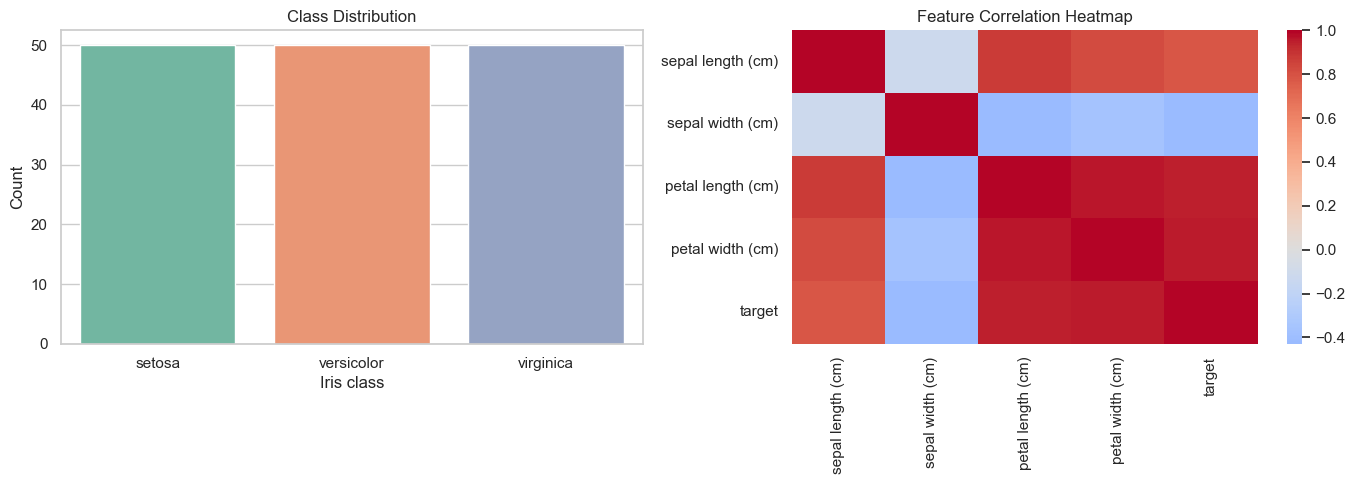

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
sns.countplot(data=df, x="target_name", hue="target_name", palette="Set2", ax=axes[0], legend=False)
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Iris class")
axes[0].set_ylabel("Count")

# Correlation heatmap
corr = df.drop(columns=["target_name"]).corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Feature Correlation Heatmap")

plt.tight_layout()
plt.show()


#### Output Analysis
- Class counts are balanced, so model comparisons are not biased by class imbalance.
- Correlation heatmap typically shows strong positive correlation between petal length and petal width.
- This supports later results where petal-based features dominate tree splits.


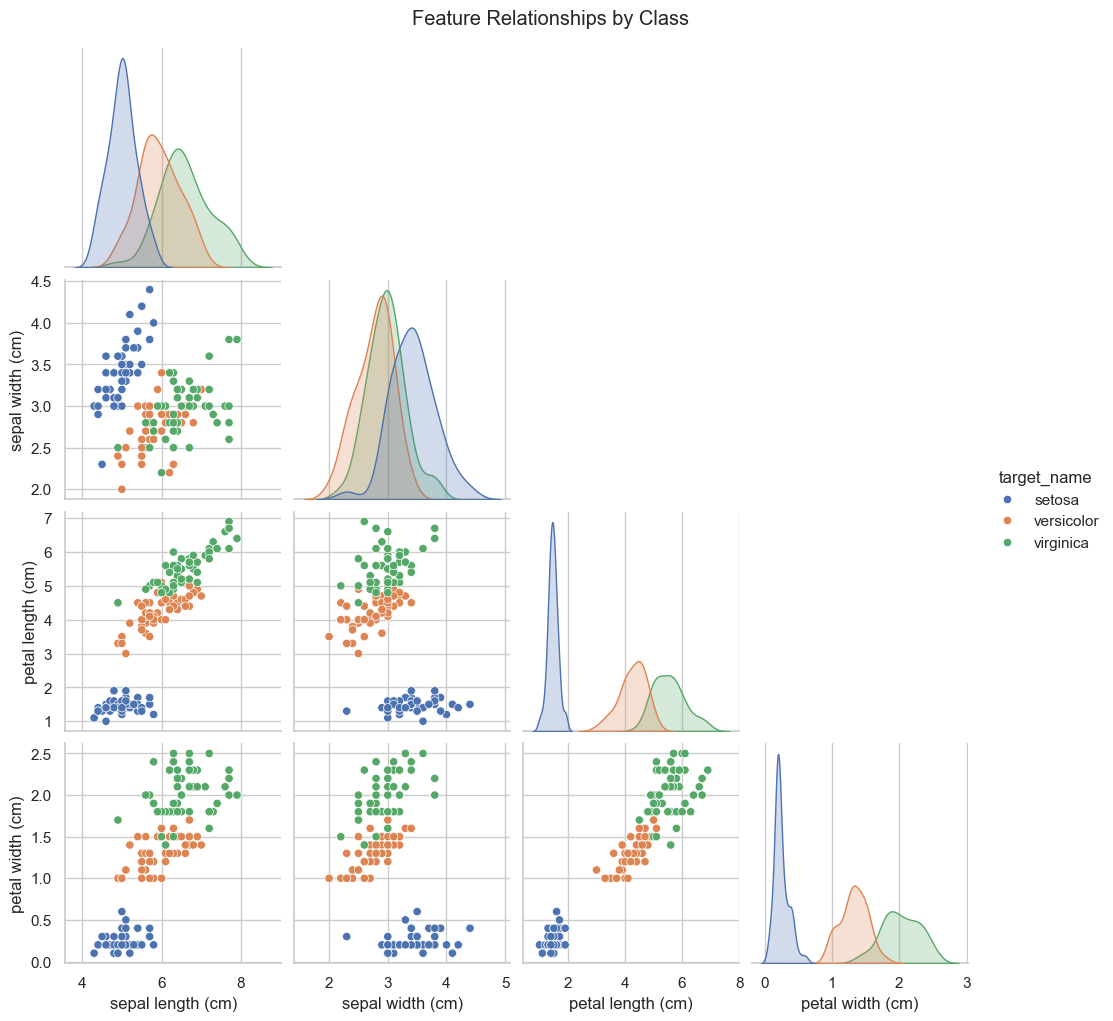

In [4]:
selected_features = [
    "sepal length (cm)",
    "sepal width (cm)",
    "petal length (cm)",
    "petal width (cm)",
    "target_name",
]
sns.pairplot(df[selected_features], hue="target_name", corner=True, diag_kind="kde")
plt.suptitle("Feature Relationships by Class", y=1.02)
plt.show()


#### Output Analysis
- Pairplot shows `setosa` as clearly separated from the other two classes.
- `versicolor` and `virginica` overlap partially, which explains most classification mistakes later.
- Petal features provide clearer class boundaries than sepal features.


## 4. Clustering Visualization (K-Means)

Even without labels, clustering can find natural groups in data.


In [5]:
X = df.drop(columns=["target", "target_name"])
y = df["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)

# Reduce to 2D only for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts.to_string())


Cluster sizes:
0    53
1    50
2    47


#### Output Analysis
- K-Means produced cluster sizes `53`, `50`, and `47`.
- These are close to balanced and close to the expected 50-per-class structure.
- The clustering signal is strong enough for a simple unsupervised method.


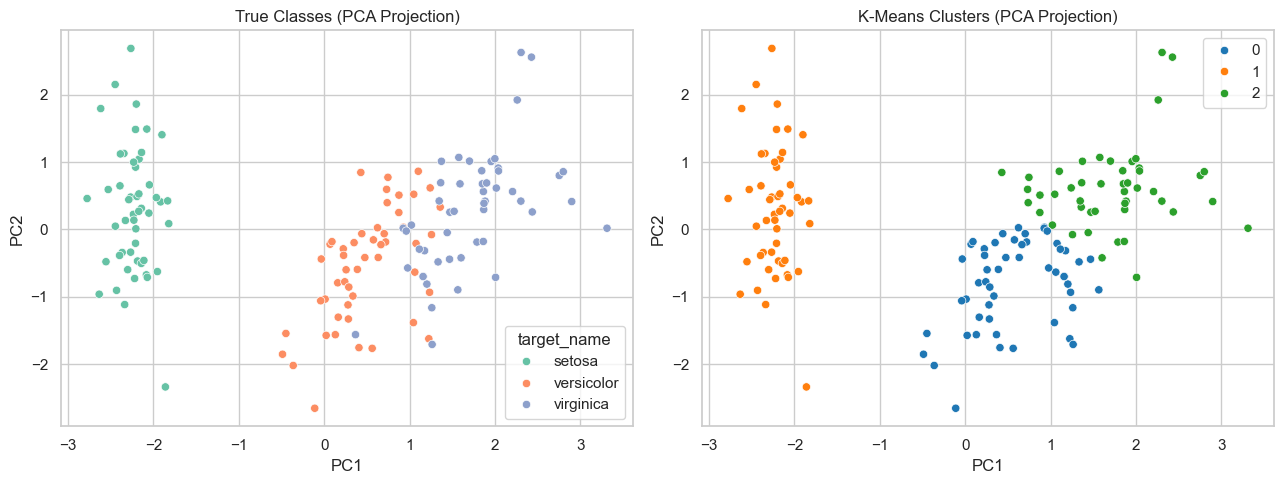

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["target_name"], palette="Set2", ax=axes[0])
axes[0].set_title("True Classes (PCA Projection)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="tab10", ax=axes[1])
axes[1].set_title("K-Means Clusters (PCA Projection)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


#### Output Analysis
- In PCA space, one cluster aligns clearly with `setosa`.
- The remaining two classes/clusters show partial overlap, which is expected for Iris.
- Visual clustering quality is good for demonstration, even without labels in training.


## 5. Decision Trees: Gini vs Entropy

From Lecture 7.2: compare split criteria and visualize the learned tree.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

def train_and_eval(criterion, depth=4):
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=depth,
        random_state=RANDOM_STATE,
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc

model_gini, preds_gini, acc_gini = train_and_eval("gini", depth=4)
model_entropy, preds_entropy, acc_entropy = train_and_eval("entropy", depth=4)

print(f"Gini accuracy:    {acc_gini:.3f}")
print(f"Entropy accuracy: {acc_entropy:.3f}")


Gini accuracy:    0.921
Entropy accuracy: 0.921


#### Output Analysis
- Both criteria gave the same test accuracy: `0.921`.
- For this dataset/split, `gini` and `entropy` are effectively equivalent.
- This lets students focus on interpretability and depth tuning rather than criterion choice alone.


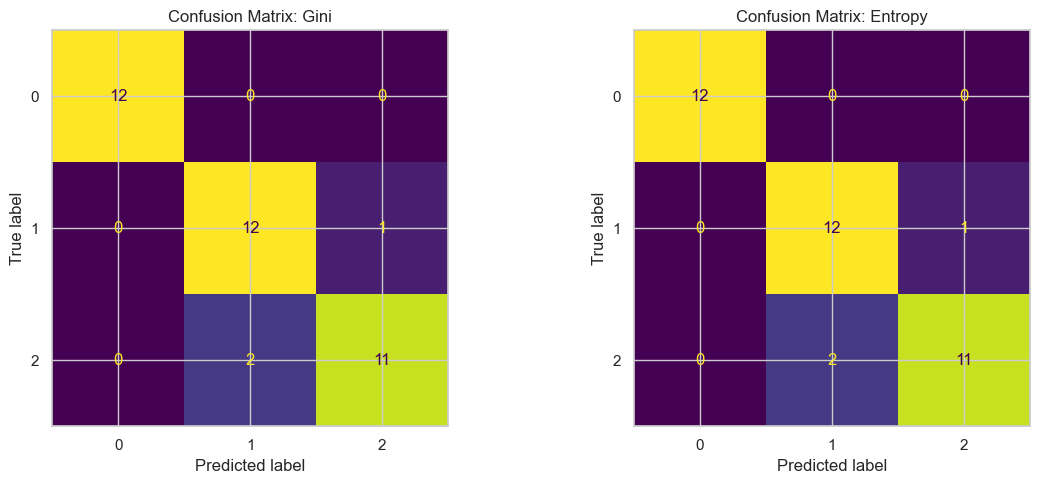

Classification report (Entropy):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_gini)).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix: Gini")

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_entropy)).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix: Entropy")

plt.tight_layout()
plt.show()

print("Classification report (Entropy):")
print(classification_report(y_test, preds_entropy, target_names=iris.target_names))


#### Output Analysis
- `setosa` is classified perfectly (precision/recall/F1 = `1.00`).
- Most errors happen between `versicolor` and `virginica`, matching the pairplot overlap.
- Macro F1 is about `0.92`, indicating strong but not perfect multiclass performance.


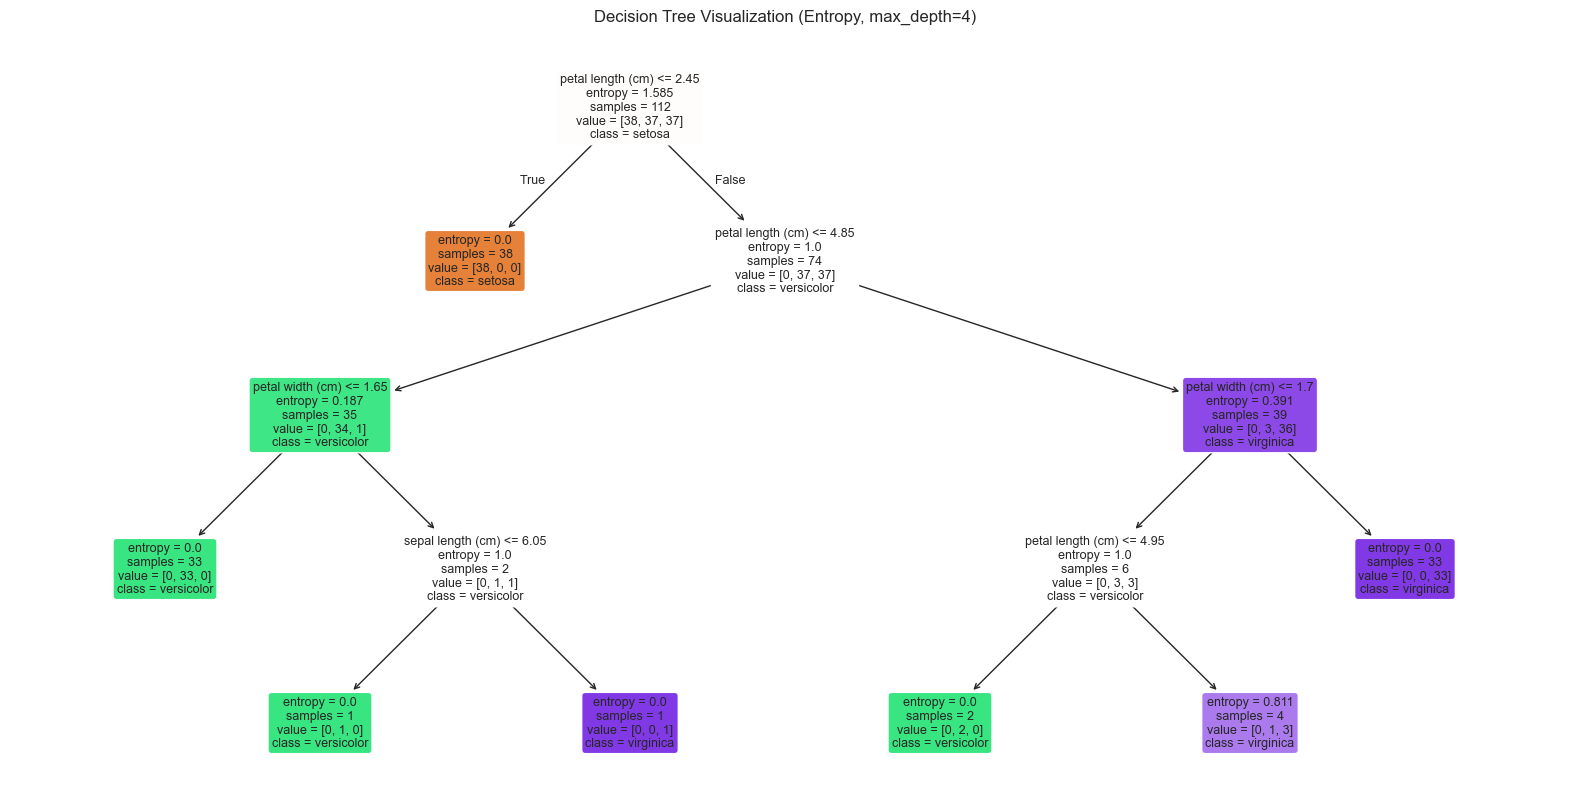

In [9]:
plt.figure(figsize=(20, 10))
plot_tree(
    model_entropy,
    feature_names=X.columns,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    fontsize=9,
)
plt.title("Decision Tree Visualization (Entropy, max_depth=4)")
plt.show()


#### Output Analysis
- The learned tree is shallow and interpretable at `max_depth=4`.
- Top decision nodes rely on petal features, which matches EDA and feature-importance outputs.
- This visualization is useful for explaining rule-based classification logic.


## 6. Model Complexity and Overfitting

Observe how tree depth changes train/test accuracy.


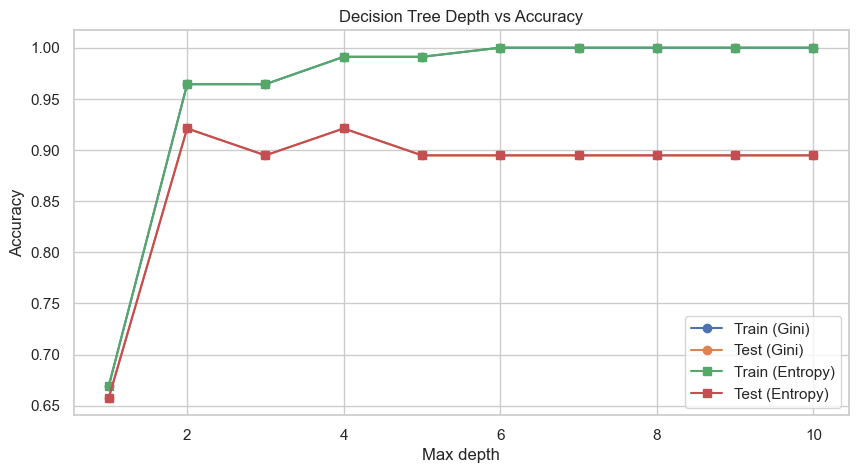

In [10]:
depths = range(1, 11)
train_scores_gini, test_scores_gini = [], []
train_scores_entropy, test_scores_entropy = [], []

for d in depths:
    m_g = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=RANDOM_STATE)
    m_e = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RANDOM_STATE)

    m_g.fit(X_train, y_train)
    m_e.fit(X_train, y_train)

    train_scores_gini.append(m_g.score(X_train, y_train))
    test_scores_gini.append(m_g.score(X_test, y_test))

    train_scores_entropy.append(m_e.score(X_train, y_train))
    test_scores_entropy.append(m_e.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores_gini, marker="o", label="Train (Gini)")
plt.plot(depths, test_scores_gini, marker="o", label="Test (Gini)")
plt.plot(depths, train_scores_entropy, marker="s", label="Train (Entropy)")
plt.plot(depths, test_scores_entropy, marker="s", label="Test (Entropy)")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Depth vs Accuracy")
plt.legend()
plt.show()


#### Output Analysis
- Test accuracy peaks around depth `2`/`4` (`~0.921`) and then drops/plateaus near `0.895`.
- Training accuracy reaches `1.0` at larger depths, indicating overfitting.
- A moderate depth is the best tradeoff between generalization and interpretability.


## 7. Feature Importance


/var/folders/cn/4_gky4xj72v72pn40z8_0vh80000gn/T/ipykernel_30400/1232696998.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values, y=importance.index, palette="viridis")


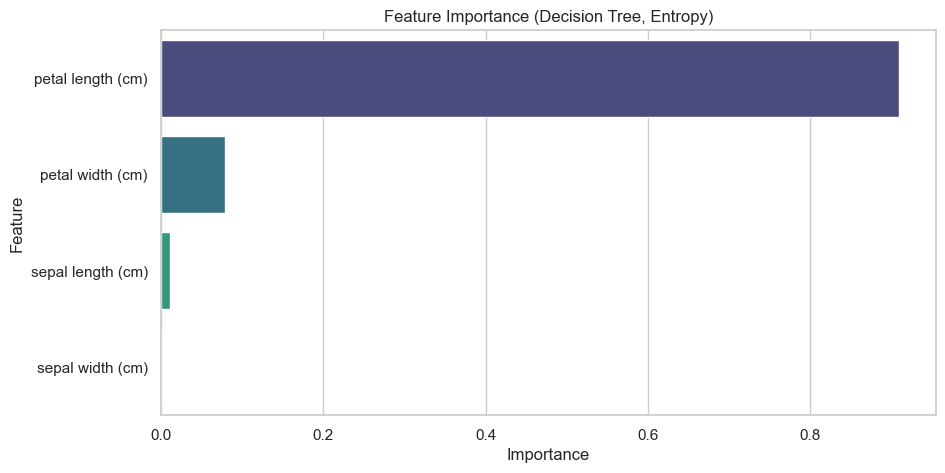

petal length (cm)    0.909274
petal width (cm)     0.079248
sepal length (cm)    0.011477
sepal width (cm)     0.000000
dtype: float64

In [11]:
importance = pd.Series(model_entropy.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importance.values, y=importance.index, palette="viridis")
plt.title("Feature Importance (Decision Tree, Entropy)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

importance.head(10)


#### Output Analysis
- `petal length (cm)` dominates importance (`~0.909`), with `petal width (cm)` second (`~0.079`).
- Sepal features contribute little; `sepal width` is near zero.
- This matches the visual separability seen in earlier EDA.


## 8. Missing Data and Imputation Techniques

Real datasets often have missing values. Below we simulate missingness and compare common imputation techniques.


In [12]:
# Simulate missing values in 10% of feature cells
missing_rate = 0.10
rng = np.random.default_rng(RANDOM_STATE)

X_missing = X.copy()
mask = rng.random(X_missing.shape) < missing_rate
X_missing = X_missing.mask(mask)

missing_total = int(X_missing.isna().sum().sum())
missing_pct = 100 * missing_total / X_missing.size
print(f"Missing cells: {missing_total} ({missing_pct:.1f}%)")

X_missing.isna().mean().sort_values(ascending=False)


Missing cells: 55 (9.2%)


petal length (cm)    0.126667
sepal length (cm)    0.100000
petal width (cm)     0.080000
sepal width (cm)     0.060000
dtype: float64

#### Output Analysis
- The run generated `55` missing cells (`9.2%`), close to the target 10%.
- Missingness is random but not perfectly uniform by column (expected with finite samples).
- This setup is suitable for comparing imputation methods under controlled noise.


In [13]:
X_train_miss, X_test_miss, y_train_miss, y_test_miss = train_test_split(
    X_missing, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

imputers = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median"),
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "knn": KNNImputer(n_neighbors=5),
}

rows = []
for name, imputer in imputers.items():
    X_train_imp = imputer.fit_transform(X_train_miss)
    X_test_imp = imputer.transform(X_test_miss)

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=RANDOM_STATE)
    clf.fit(X_train_imp, y_train_miss)
    preds = clf.predict(X_test_imp)

    rows.append(
        {
            "imputer": name,
            "accuracy": accuracy_score(y_test_miss, preds),
            "remaining_missing_train": int(np.isnan(X_train_imp).sum()),
            "remaining_missing_test": int(np.isnan(X_test_imp).sum()),
        }
    )

imputation_results = pd.DataFrame(rows).sort_values("accuracy", ascending=False)
imputation_results


,imputer,accuracy,remaining_missing_train,remaining_missing_test
0,mean,0.894737,0,0
1,median,0.894737,0,0
3,knn,0.894737,0,0
2,most_frequent,0.868421,0,0


#### Output Analysis
- `mean`, `median`, and `knn` produced the same accuracy (`0.8947`) in this run.
- `most_frequent` performed worse (`0.8684`), which is typical for continuous features.
- All imputers removed missing values completely (`0` remaining missing cells).


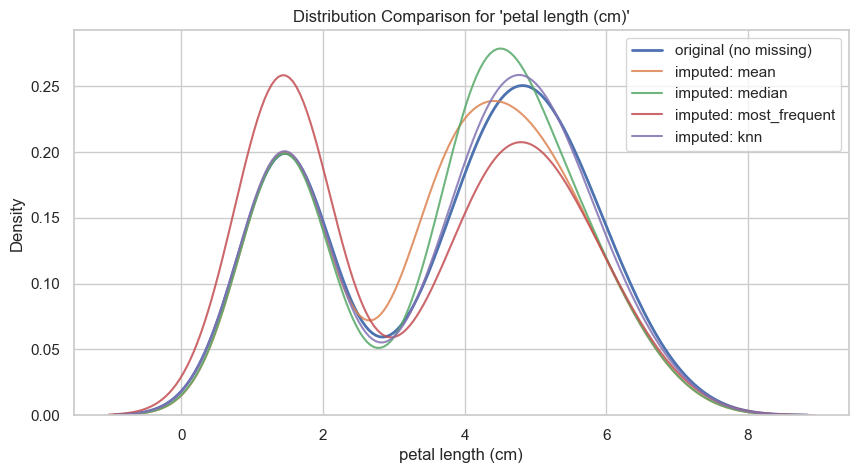

In [14]:
feature = "petal length (cm)"
feature_idx = X.columns.get_loc(feature)

plt.figure(figsize=(10, 5))
sns.kdeplot(X[feature], label="original (no missing)", linewidth=2)

for name, imputer in imputers.items():
    X_imp_full = imputer.fit_transform(X_missing)
    sns.kdeplot(X_imp_full[:, feature_idx], label=f"imputed: {name}", alpha=0.85)

plt.title(f"Distribution Comparison for '{feature}'")
plt.xlabel(feature)
plt.ylabel("Density")
plt.legend()
plt.show()


#### Output Analysis
- Imputation changes the feature distribution in different ways.
- `mean`/`median` tend to shrink variance, while `knn` often preserves local structure better.
- Distribution checks are important because equal accuracy can still hide data-distortion effects.


## 9. Variant Tasks for 10 Students

Assign one variant to each student. Every variant includes a few tasks to complete.

### Variant 1
1. Run K-Means with `n_clusters=2`, `3`, and `4`.
2. Compare cluster sizes and PCA scatter plots in a small table/figure.
3. Explain which `k` works best and why.

### Variant 2
1. Keep `k=3` and test K-Means with and without `StandardScaler`.
2. Compare PCA cluster plots and cluster separation quality.
3. Write a short conclusion about scaling impact.

### Variant 3
1. Build decision trees with `max_depth=2`, `4`, and `8` using `criterion='gini'`.
2. Compare train/test accuracy in one plot.
3. Explain where overfitting starts.

### Variant 4
1. Build decision trees with `criterion='gini'` and `criterion='entropy'` at `max_depth=4`.
2. Compare confusion matrices and macro F1.
3. Decide which criterion is better on this dataset.

### Variant 5
1. Simulate missingness at `10%` and `25%`.
2. Compare `SimpleImputer(mean)` and `SimpleImputer(median)`.
3. Report which method is more stable as missingness increases.

### Variant 6
1. Simulate missingness at `15%`.
2. Compare `SimpleImputer(most_frequent)` vs `KNNImputer`.
3. Evaluate both using decision-tree test accuracy.

### Variant 7
1. After imputation, compare feature distributions for two features (not only `flavanoids`).
2. Show KDE plots for original vs imputed data.
3. Identify which feature is most sensitive to imputation choice.

### Variant 8
1. Train an entropy tree (`max_depth=4`).
2. Extract top-5 most important features.
3. Remove the top-1 feature, retrain, and compare accuracy.

### Variant 9
1. Add 5-fold cross-validation for decision trees (`gini` and `entropy`).
2. Report mean and std accuracy for each criterion.
3. Compare CV results with the single train/test split.

### Variant 10
1. Create one final comparison table with the best result from clustering, tree tuning, and imputation.
2. Select your recommended pipeline for this dataset.
3. Provide a 5-7 sentence final summary for a non-technical audience.
